In [1]:
from keypoint_network import build_kpextractor64, preproc_dataset
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


In [2]:
model_loc = 'all_kpts_64'
dset_loc = 'all_kpts_64'

In [3]:
with open(join(dataset_loc, "Flukes/kpts/%s/model.pkl" % model_loc), 'r') as f:
    model = pickle.load(f)

test_dset = load_dataset(join(dataset_loc, "Flukes/kpts/%s" % dset_loc), normalize_method='meansub')

Loading /home/zach/data/Flukes/kpts/all_kpts_64
Took 1.61 seconds


In [4]:
X = T.tensor4()


kpextractor = build_kpextractor64()
ll.set_all_param_values(kpextractor, model)
model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(kpextractor)]
#segmenter_out = ll.get_output(segmenter, X, deterministic=True)
kpextractor_fn = tfn([X], model_outputs)

dset_for_model = {section:preproc_dataset(test_dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:kpextractor_fn(dset_for_model[sec]['X']) for sec in ['train','valid','test']}

In [5]:
[np.linalg.norm(i) for i in ll.get_all_param_values(kpextractor)]

[2.4590831,
 0.28518978,
 0.19161776,
 2.4469926,
 72.643623,
 0.10399529,
 3.8678243,
 0.26791275,
 0.33415103,
 3.1959205,
 2.2742674,
 6.4040518,
 5.556602,
 0.39610112,
 0.57382202,
 3.984551,
 4.0503383,
 8.8724499,
 8.1962223,
 0.64434218,
 0.45068392,
 4.7485471,
 13.004111,
 12.711939,
 8.2110481,
 1.0591009,
 1.8482807,
 5.4283676,
 5.6197147,
 120.79364,
 6.9696393,
 1.1883124,
 6.9584079,
 6.3544087,
 6.2342262,
 9.3488922,
 11.670501,
 1.0116781]

In [6]:
print(ll.get_output_shape(ll.get_all_layers(kpextractor)))

[(None, 1, 64, 64), (None, 8, 64, 64), (None, 8, 32, 32), (None, 8, 32, 32), (None, 16, 32, 32), (None, 16, 16, 16), (None, 16, 16, 16), (None, 32, 16, 16), (None, 32, 8, 8), (None, 32, 8, 8), (None, 64, 8, 8), (None, 64, 2, 2), (None, 64, 2, 2), (None, 128), (None, 128), (None, 64), (None, 64), (None, 6), (None, 3, 2)]


(64, 64)
uint8
32


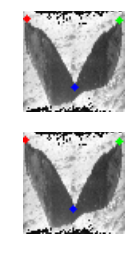

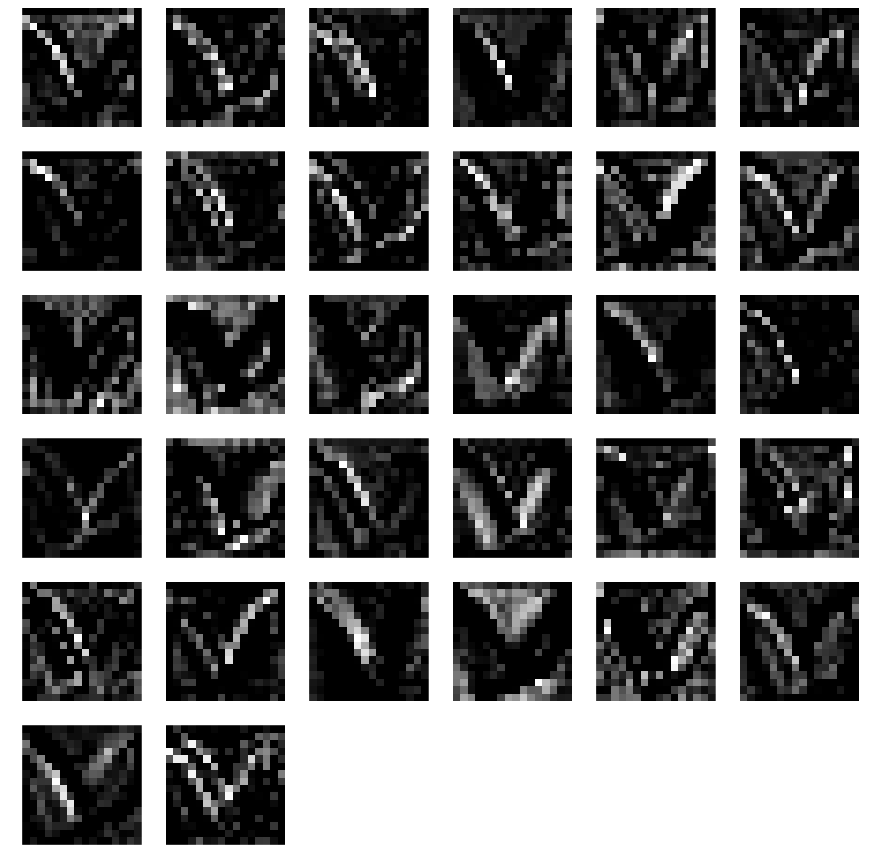

In [18]:
import matplotlib.pyplot as plt
import cv2
import random
%matplotlib inline

def drawPoints(points, img):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(color_img, (int(points[0,0]), int(points[0,1])), 2, (255,0,0), -1) # left
    cv2.circle(color_img, (int(points[1,0]), int(points[1,1])), 2, (0,255,0), -1) # right
    cv2.circle(color_img, (int(points[2,0]), int(points[2,1])), 2, (0,0,255), -1) # notch
    return color_img

def show_output(originals, true_labels, outputs, ind, stage=-1):
    # the [0] indexes into the channel
    original = ((originals[ind][0]) + test_dset['mean']).astype(np.uint8).T
    print(original.shape)
    print(original.dtype)
    true_points = true_labels[ind]
    sizey, sizex = original.shape[-2:]
    scale_mat = np.array([sizex, sizey]*3).reshape(3,2)
    true_points_scaled = true_points
    #true_points_scaled = (true_points * scale_mat + scale_mat) / 2 
    # draw left right notch on the original image
    gt_drawn = drawPoints(true_points_scaled, original)
    
    pred_points = outputs[-1][ind]
    #pred_points_scaled = (pred_points * scale_mat + scale_mat) / 2
    pred_points_scaled = pred_points
    pred_drawn = drawPoints(pred_points_scaled, original)

        
    network_stage = outputs[stage][ind].swapaxes(0,2)
    #print(output)
    f, trueax = plt.subplots(2)
    for i in trueax:
        i.axis('off')
    trueax[0].imshow(gt_drawn)
    trueax[1].imshow(pred_drawn)
    
    nfilters = network_stage.shape[-1]
    print(nfilters)
    square_size = int(np.sqrt(nfilters) + 0.5)
    #print(square_size)
    plt.gray()
    f, netax = plt.subplots(square_size, square_size, figsize=(15,15))
    for i in range(square_size*square_size):
        #netax.set_gray()
        this_ax = netax[i // square_size, i % square_size]
        this_ax.axis('off')
        #this_ax.get_xaxis().set_visible(False)
        #this_ax.get_yaxis().set_visible(False)
        if i < nfilters:
            this_ax.imshow(network_stage[:,:,i], interpolation='none')
    #ax[2].imshow(network_stage)

sec = 'valid'
show_output(dset_for_model[sec]['X'], dset_for_model[sec]['y'], point_outputs[sec], 
            random.choice(range(dset_for_model[sec]['X'].shape[0])), stage=7)

[[  2.72222233   6.27492857]
 [ 60.29914474   6.61965799]
 [ 31.48860359  33.05698013]]
[[  2.50466108   5.76336813]
 [ 60.43479156   6.08570957]
 [ 31.3886528   33.03858566]]
2.38559
4.02516
4.67354


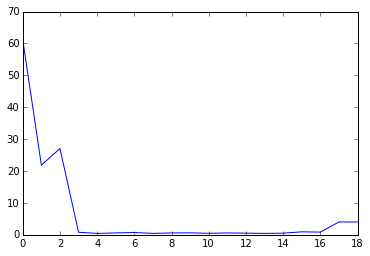

In [17]:
#print(len(point_outputs_valid))
n_layers = len(point_outputs[sec])
#plt.yscale('log')
plt.plot([np.average(np.std(point_outputs[sec][i],axis=0)) for i in range(n_layers)])
avg_prediction = np.average(dset_for_model[sec]['y'],axis=0)
print(avg_prediction)
print(np.average(point_outputs[sec][-1],axis=0))
def eucl_loss(pred, y):
    return np.average(np.linalg.norm(pred - y, axis=2),axis=(0,1))

print(eucl_loss(point_outputs[sec][-1], dset_for_model[sec]['y']))
print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

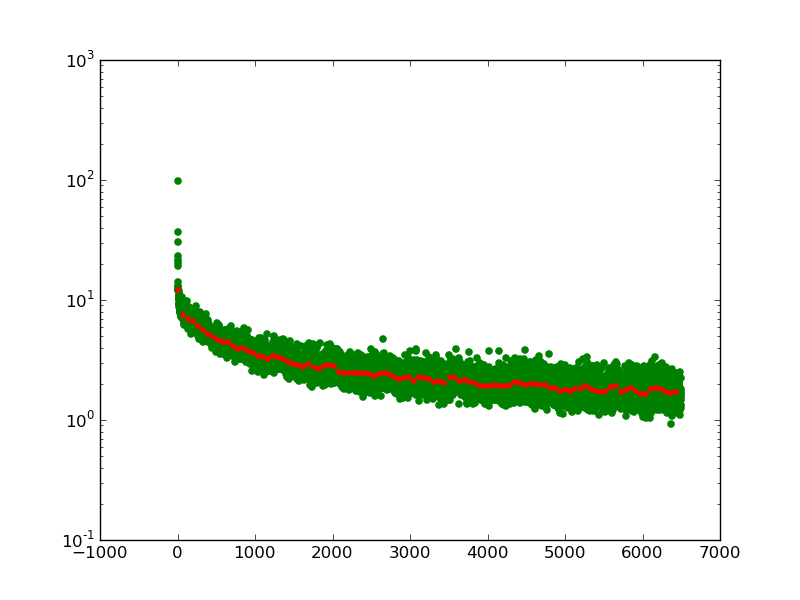

In [34]:
from IPython.display import Image 
Image(filename='./losses.png')